# Installation [Running this cell required!] <a name="installation"></a>

First, we need to install the necessary libraries. This includes TabPFN itself, as well as other libraries for data manipulation and baseline model comparisons. If you are asked to restart the runtime after installation, please do so.


In [1]:
## Base library Installation
# Install Baselines for model comparison
!uv pip install catboost xgboost

# Install the datasets library for loading example data
!uv pip install datasets

# Install rich for better and more readable printing
!uv pip install rich

## TabPFN Installation optimized for Google Colab
# Install the TabPFN Client library
!uv pip install tabpfn-client

# Install TabPFN extensions for additional functionalities
!uv pip install tabpfn-extensions[all]

# Install tabpfn
!uv pip install tabpfn

Using Python 3.12.12 environment at: /usr
Resolved 21 packages in 208ms
Prepared 1 package in 1.16s
Installed 1 package in 6ms
 + catboost==1.2.8
Using Python 3.12.12 environment at: /usr
Audited 1 package in 101ms
Using Python 3.12.12 environment at: /usr
Audited 1 package in 90ms
Using Python 3.12.12 environment at: /usr
Resolved 33 packages in 544ms
Prepared 4 packages in 38ms
Installed 4 packages in 3ms
 + backoff==2.2.1
 + password-strength==0.0.3.post2
 + sseclient-py==1.8.0
 + tabpfn-client==0.2.8
Using Python 3.12.12 environment at: /usr
Resolved 96 packages in 822ms
Prepared 19 packages in 549ms
Uninstalled 1 package in 8ms
Installed 19 packages in 105ms
 + autogluon-common==1.4.0
 + autogluon-core==1.4.0
 + autogluon-features==1.4.0
 + autogluon-tabular==1.4.0
 + boto3==1.42.21
 + botocore==1.42.21
 + ecos==2.0.14
 + eval-type-backport==0.3.1
 + galois==0.4.10
 + jmespath==1.0.1
 + posthog==6.9.3
 - requests==2.32.4
 + requests==2.32.5
 + s3transfer==0.16.0
 + scikit-survival

***Note: remember to restart the runtime after the installation.***

# Necessary Imports for the Notebook [Running this cell required!]

Now that the libraries are installed, let's import all the necessary modules for this notebook.




In [2]:
# Standard Library Imports

# TabPFN and Extensions

try:
    from tabpfn_extensions.post_hoc_ensembles.sklearn_interface import (
        AutoTabPFNClassifier,
    )

    from tabpfn import TabPFNClassifier, TabPFNRegressor
except ImportError:
    raise ImportError(
        "Warning: Could not import TabPFN / TabPFN extensions. Please run installation above and restart the session afterwards (Runtime > Restart Session)."
    )

# Data Science & Visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

# Other ML Models
from catboost import CatBoostClassifier, CatBoostRegressor

# Notebook UI/Display
from IPython.display import Markdown, display
from rich.console import Console
from rich.panel import Panel
from rich.prompt import Prompt
from rich.rule import Rule
from sklearn.compose import make_column_selector, make_column_transformer

# Scikit-Learn: Data & Preprocessing
from sklearn.datasets import fetch_openml, load_breast_cancer

# Scikit-Learn: Models
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from xgboost import XGBClassifier, XGBRegressor

# This transformer will be used to handle categorical features for the baseline models
column_transformer = make_column_transformer(
    (
        OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
        make_column_selector(dtype_include=["object", "category"]),
    ),
    remainder="passthrough",
)

# Backend Selection [Running this cell required!] <a name="backend-selection"></a>


TabPFN can be run in two ways: locally on your machine (if you have a GPU) or by using the TabPFN client, which sends the data to a server for computation.
In your project you would either use the **local** version (which requires a GPU) with:
```python
# Simple import for TabPFN
from tabpfn import TabPFNClassifier

# Now you can use it like any other sklearn classifier
# model = TabPFNClassifier()
print("TabPFNClassifier imported successfully.")
```

or the **client** API (which uses a remote server):

```python
# Simple import for TabPFN
from tabpfn_client import TabPFNClassifier

# Now you can use it like any other sklearn classifier
# model = TabPFNClassifier()
print("TabPFNClassifier imported successfully.")
```

If you select **local** and it's your first time using the model, you'll need to accept the license agreement and log into Hugging Face.
You'll be prompted with instructions on how to do this the first time you fit the model.

For demonstration purposes, the cell below provides an interactive way to switch between local mode and the client:


In [3]:
console = Console()

console.print(Panel.fit("[bold magenta]TabPFN Demo: Backend Selection[/bold magenta]"))
console.print("\nThis script can run TabPFN using one of two backends:")
console.print("  [bold]1. local:[/bold] Uses a local GPU (NVIDIA). Requires CUDA.")
console.print(
    "  [bold]2. client:[/bold] Uses the TabPFN API. Requires an internet connection and a free account."
)

backend = Prompt.ask(
    "\n[bold]Choose your backend[/bold] - If not field to enter is shown restart the cell.",
    choices=["client", "local"],
    default="client",
)
# backend = "client"

console.print(
    f"\n✅ You have selected the '[bold green]{backend}[/bold green]' backend."
)

console.print(Rule(f"[bold]Setting up [cyan]{backend}[/cyan] backend[/bold]"))


if backend == "local":
    !uv pip install huggingface_hub

    console.print("Attempting local backend setup...")
    import torch

    if not torch.cuda.is_available():
        console.print(
            "[bold red]Error:[/bold red] GPU device not found. For fast training, please enable GPU.",
            style="red",
        )
        console.print(
            "In Colab: Go to [bold]Runtime -> Change runtime type -> Hardware accelerator -> GPU.[/bold]",
            style="yellow",
        )
        raise SystemError("GPU device not found.")
    console.print(
        "[bold green]✅ GPU is available.[/bold green] Importing local TabPFN library..."
    )

    from tabpfn import TabPFNClassifier, TabPFNRegressor

    console.print("[bold green]✅ TabPFN (local) imported successfully.[/bold green]")
elif backend == "client":
    console.print("Attempting client backend setup...")
    console.print("Importing TabPFN client library...")
    from tabpfn_client import TabPFNClassifier, TabPFNRegressor, init

    init()
    console.print("[bold green]✅ TabPFN (client) initialized.[/bold green]")

╭────────────────────────────────╮
│ TabPFN Demo: Backend Selection │
╰────────────────────────────────╯

This script can run TabPFN using one of two backends:

1. local: Uses a local GPU (NVIDIA). Requires CUDA.

2. client: Uses the TabPFN API. Requires an internet connection and a free account.

Choose your backend - If not field to enter is shown restart the cell. [client/local] (client):

client


✅ You have selected the 'client' backend.

──────────────────────────────────────────── Setting up client backend ────────────────────────────────────────────

Attempting client backend setup...

Importing TabPFN client library...

########  ########   ###  #########  #########       ###         #####     ########  ########
     ###        ##   ###  ###   ###        ###       ###        ###  ###   ##   ###  ###     
########  #######    ###  ###   ###  #######         ###        ########   ######    ########
###       ###   ##   ###  ###   ###  ###   ###       ###        ###  ###   ##   ###       ###
###       ###   ##   ###  #########  ###   ###       ########   ###  ###   ########  ########                      

Thanks for being part of the journey

TabPFN is under active development, please help us improve and report any bugs/ideas you find.

Report issues: https://github.com/priorlabs/tabpfn-client/issues

Press Ctrl+C anytime to exit


Opening browser for login. Please complete the login/registration process in your browser and return here.


Could not open browser automatically. Falling back to command-line login...



[1]     Create a TabPFN account     
[2]     Login to your TabPFN account
[q]     Quit

→ Choose (1/2/q):

2


Login

Email:

hauld@soict.hust.edu.vn
Password: ··········


Output()

Login successful!

✅ TabPFN (client) initialized.

#LOAD DATASET

## For Culverts

In [4]:
base_dataset = "Culvert"

import pandas as pd

# Read the tab-separated file
dfSD = pd.read_csv("//content/Culvert.tsv", sep="\t")
print(dfSD.shape)
# Show first rows
print(dfSD.head())
dfSD["Source"].value_counts()


(80, 7)
   ww  blk  s        Fd   dta  dsa                Source
0   0    0  0  8.179707  0.12  0.9  GalanandGonzalez2019
1   0    0  0  6.278284  0.16  2.1  GalanandGonzalez2019
2   0    0  0  5.560766  0.63  1.6  GalanandGonzalez2019
3   0    0  0  4.305109  1.00  0.9  GalanandGonzalez2019
4   0    0  0  7.971627  0.23  2.5  GalanandGonzalez2019


,count
Source,
GalanandGonzalez2019,80


In [5]:
selected_Source = ["GalanandGonzalez2019"]

dfSD_filtered = dfSD[dfSD["Source"].isin(selected_Source)]
print(dfSD_filtered.shape)

X, y = dfSD_filtered.drop(columns=["dsa", "Source"]), dfSD_filtered["dsa"]

(80, 7)


##For Sluices

In [6]:

import pandas as pd
# Read the tab-separated file
dfSD = pd.read_csv("/content/Sluice.tsv", sep="\t")

base_dataset = "Sluice"

print(dfSD.shape)
# Show first rows
print(dfSD.head())

dfSD["Source"].value_counts()

(432, 7)
     La         F    dta   D50a         Fd   dsa            Source
0  55.0  4.868950  12.80  0.080  13.401345  5.90  DeyandSarkar2008
1  50.0  4.757204  12.30  0.080  13.093773  6.10  DeyandSarkar2008
2  50.0  4.182508  11.40  0.080  11.511975  5.90  DeyandSarkar2008
3  40.0  4.097910  11.28  0.064  12.610446  4.96  DeyandSarkar2008
4  40.0  3.855176  10.24  0.064  11.863485  4.08  DeyandSarkar2008


,count
Source,
DeyandSarkar2006,200
Aamir2022,123
Sarkar2005,41
DeyandSarkar2008,39
VermaandGoel2005,29


In [7]:
selected_Source = list(dfSD["Source"])

dfSD_filtered = dfSD[dfSD["Source"].isin(selected_Source)]
print(dfSD_filtered.shape)

X, y = dfSD_filtered.drop(columns=["dsa", "Source"]), dfSD_filtered["dsa"]

(432, 7)


In [ ]:
# @title
grouped_stats = dfSD_filtered.groupby('Source').describe().transpose()
display(grouped_stats)

In [8]:
# Step 1: Grouped descriptive statistics
grouped_stats = (
    dfSD_filtered
    .groupby("Source")
    .describe()
    .swaplevel(0, 1, axis=1)   # (feature, stat) → (stat, feature)
    .sort_index(axis=1)
    .stack(level=0)            # move statistic to rows
)

# Step 2: Rename index levels
grouped_stats.index.names = ["Source", "Statistic"]

# Step 3: Order statistics
stat_order = ["count", "mean", "std", "min", "25%", "50%", "75%", "max"]
grouped_stats = grouped_stats.reindex(stat_order, level="Statistic")

# Step 4: Move 'dsa' to the last column
if "dsa" in grouped_stats.columns:
    cols = [c for c in grouped_stats.columns if c != "dsa"] + ["dsa"]
    grouped_stats = grouped_stats[cols]

# Step 5: Enforce correct numeric formatting
# 5a. Round all non-count statistics
mask_non_count = grouped_stats.index.get_level_values("Statistic") != "count"
grouped_stats.loc[mask_non_count] = grouped_stats.loc[mask_non_count].round(3)

# 5b. Force count to integer (no decimals)
mask_count = grouped_stats.index.get_level_values("Statistic") == "count"
grouped_stats.loc[mask_count] = (
    grouped_stats.loc[mask_count]
    .astype(int)
)

display(grouped_stats)


/tmp/ipython-input-3073278999.py:8: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(level=0)            # move statistic to rows


D50a        F       Fd       La      dta  \
Source           Statistic                                                
Aamir2022        count      123.000  123.000  123.000  123.000  123.000   
                 mean         0.371    6.005    7.999   57.480   16.516   
                 std          0.309    4.221    4.075   27.824    8.725   
                 min          0.018    1.460    2.703   20.000    6.667   
                 25%          0.178    2.320    4.281   33.333   10.000   
                 50%          0.267    4.246    6.398   50.000   13.333   
                 75%          0.534   12.056   12.699  100.000   21.000   
                 max          1.340   12.056   15.686  100.000   40.000   
DeyandSarkar2006 count      200.000  200.000  200.000  200.000  200.000   
                 mean         0.143    3.518    8.528   34.913   10.706   
                 std          0.093    0.701    3.439    6.785    1.517   
                 min          0.017    2.372    3.309   26.667    6.967   
                 25%          0.064    3.128    5.962   32.000    9.667   
                 50%          0.124    3.571    7.780   33.333   10.867   
                 75%          0.190    4.098   10.633   40.000   11.985   
                 max          0.442    4.869   22.120   55.000   13.856   
DeyandSarkar2008 count       39.000   39.000   39.000   39.000   39.000   
                 mean         0.158    3.856    8.367   38.385   11.008   
                 std          0.082    0.755    2.634    8.722    1.116   
                 min          0.053    2.581    4.493   26.667    9.067   
                 25%          0.080    3.154    6.319   32.000   10.240   
                 50%          0.149    4.098    7.780   40.000   11.280   
                 75%          0.200    4.183   10.633   40.000   11.400   
                 max          0.300    4.869   13.401   55.000   12.800   
Sarkar2005       count       41.000   41.000   41.000   41.000   41.000   
                 mean         0.152    3.808    8.562   38.138   10.946   
                 std          0.084    0.769    2.724    8.572    1.123   
                 min          0.033    2.581    4.493   26.667    9.067   
                 25%          0.080    3.154    6.512   32.000   10.208   
                 50%          0.149    4.098    7.780   40.000   11.280   
                 75%          0.200    4.183   11.116   40.000   11.400   
                 max          0.300    4.869   13.587   55.000   12.770   
VermaandGoel2005 count       29.000   29.000   29.000   29.000   29.000   
                 mean         0.186    2.760    4.782   28.138   13.391   
                 std          0.086    1.440    1.461   16.198    7.233   
                 min          0.100    1.235    3.040    9.333    3.667   
                 25%          0.100    1.235    3.040   14.667    8.300   
                 50%          0.150    2.269    4.561   22.000   10.500   
                 75%          0.300    4.623    6.571   30.000   15.600   
                 max          0.300    4.623    6.571   60.000   29.700   

                                dsa  
Source           Statistic           
Aamir2022        count      123.000  
                 mean         5.040  
                 std          3.766  
                 min          0.333  
                 25%          2.167  
                 50%          4.200  
                 75%          7.000  
                 max         12.800  
DeyandSarkar2006 count      200.000  
                 mean         4.347  
                 std          1.132  
                 min          2.267  
                 25%          3.515  
                 50%          4.090  
                 75%          5.120  
                 max          8.160  
DeyandSarkar2008 count       39.000  
                 mean         4.191  
                 std          1.214  
                 min          0.600  
                 25%          3.367  
      

#PERFORMANCE COMPARISON

## Prepare

In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    make_scorer,
)


In [10]:
# RMSE (negative because sklearn assumes higher = better)
rmse_scorer = make_scorer(
    lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    greater_is_better=False,
)

# Pearson correlation coefficient
corr_scorer = make_scorer(
    lambda y_true, y_pred: np.corrcoef(y_true, y_pred)[0, 1]
)


In [11]:
models = [
    ("TabPFN", TabPFNRegressor(random_state=42)),
    # ("TabPFN", TabPFNRegressor(model_path="/content/tabpfn-v2.5-regressor-v2.5_default.ckpt",random_state=42)),
    (
        "RandomForest",
        make_pipeline(
            column_transformer,
            RandomForestRegressor(random_state=42),
        ),
    ),
    (
        "XGBoost",
        make_pipeline(
            column_transformer,
            XGBRegressor(random_state=42),
        ),
    ),
    (
        "CatBoost",
        make_pipeline(
            column_transformer,
            CatBoostRegressor(random_state=42, verbose=0),
        ),
    ),
]


In [12]:
n_splits = 4
cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)


##Start

In [13]:
# @title
import numpy as np
import pandas as pd

scoring = {
    "R2": "r2",
    "RMSE": rmse_scorer,
    "MAE": "neg_mean_absolute_error",
    "MAPE": "neg_mean_absolute_percentage_error",
    "Corr": corr_scorer,
}

results = []

def mean_std_str(values, negate=False):
    """Return formatted string: mean (± std), rounded to 3 decimals"""
    if negate:
        values = -values
    mean = np.mean(values)
    std = np.std(values, ddof=1)  # sample std
    return f"{mean:.3f} (±{std:.3f})"

for name, model in models:
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=scoring,
        n_jobs=1,
        verbose=1,
    )

    results.append({
        "Model": name,
        "R2": mean_std_str(cv_results["test_R2"]),
        "RMSE": mean_std_str(cv_results["test_RMSE"], negate=True),
        "MAE": mean_std_str(cv_results["test_MAE"], negate=True),
        "MAPE": mean_std_str(cv_results["test_MAPE"], negate=True),
        "Corr": mean_std_str(cv_results["test_Corr"]),
    })

df_results = pd.DataFrame(results)
df_results.sort_values("RMSE")

Processing: 100%|██████████| [00:02<00:00]
Processing: 100%|██████████| [00:01<00:00]
Processing: 100%|██████████| [00:01<00:00]
Processing: 100%|██████████| [00:00<00:00]
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   20.3s finished
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.8s finished


,Model,R2,RMSE,MAE,MAPE,Corr
0,TabPFN,0.834 (±0.027),0.946 (±0.042),0.422 (±0.030),0.154 (±0.038),0.915 (±0.016)
1,RandomForest,0.812 (±0.072),0.990 (±0.156),0.487 (±0.067),0.166 (±0.043),0.903 (±0.039)
3,CatBoost,0.815 (±0.052),0.991 (±0.105),0.473 (±0.047),0.163 (±0.041),0.906 (±0.028)
2,XGBoost,0.784 (±0.066),1.071 (±0.132),0.468 (±0.061),0.155 (±0.036),0.890 (±0.038)


In [14]:
print(df_results.sort_values("RMSE"))


          Model              R2            RMSE             MAE  \
0        TabPFN  0.834 (±0.027)  0.946 (±0.042)  0.422 (±0.030)   
1  RandomForest  0.812 (±0.072)  0.990 (±0.156)  0.487 (±0.067)   
3      CatBoost  0.815 (±0.052)  0.991 (±0.105)  0.473 (±0.047)   
2       XGBoost  0.784 (±0.066)  1.071 (±0.132)  0.468 (±0.061)   

             MAPE            Corr  
0  0.154 (±0.038)  0.915 (±0.016)  
1  0.166 (±0.043)  0.903 (±0.039)  
3  0.163 (±0.041)  0.906 (±0.028)  
2  0.155 (±0.036)  0.890 (±0.038)  


# MODEL INTERPRETABILITY <a name="interpretability"></a>

Understanding *why* a model makes certain predictions is crucial for building trust and for debugging. The `tabpfn-extensions` library provides tools for model interpretability. We'll look at SHAP (SHapley Additive exPlanations) values, which show the impact of each feature on a specific prediction.

### Introduction to Shapley Values

Next, we'll use SHAP to understand our model's predictions. SHAP values break down a prediction to show the contribution of each feature, helping us see which factors are most influential for a given data point.


## Start

In [15]:
feature_names = X.columns.to_numpy()
feature_names

array(['La', 'F', 'dta', 'D50a', 'Fd'], dtype=object)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but TabPFNRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but TabPFNRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but TabPFNRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but TabPFNRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but TabPFNRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklea

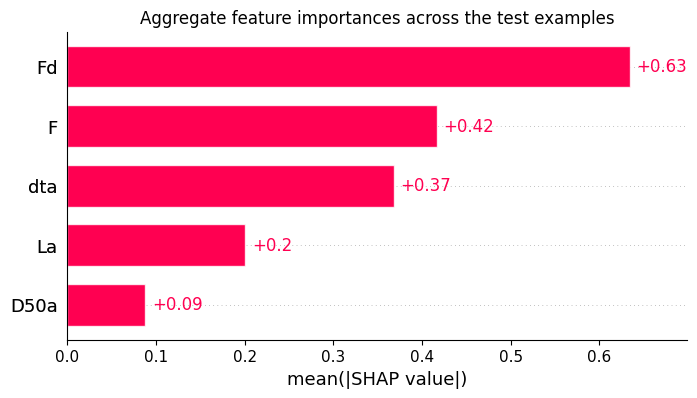

/usr/local/lib/python3.12/dist-packages/tabpfn_extensions/interpretability/shap.py:137: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values=shap_values, show=False)


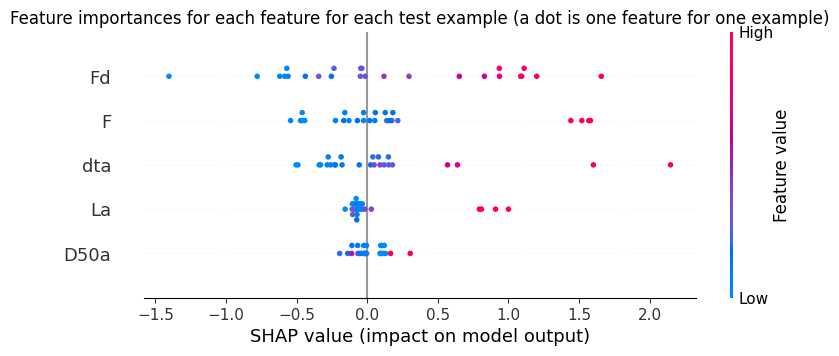

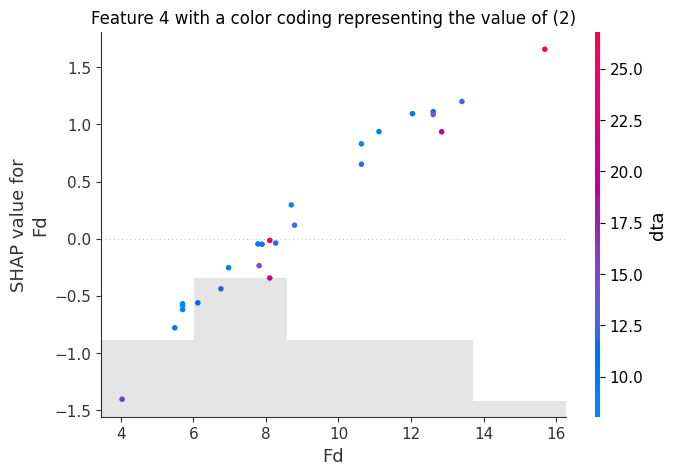

In [16]:
from tabpfn import TabPFNRegressor
from tabpfn_extensions import interpretability
from sklearn.model_selection import train_test_split

# X, y already defined
feature_names = X.columns.to_numpy()

n_samples_test, n_samples_train = 25, 50

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42
)

# Initialize and train regressor
# reg = TabPFNRegressor()
reg = TabPFNRegressor(
    model_path="/content/tabpfn-v2.5-regressor-v2.5_default.ckpt"
)

reg.fit(
    X_train.iloc[:n_samples_train],
    y_train.iloc[:n_samples_train]
)

# Compute SHAP values
shap_values = interpretability.shap.get_shap_values(
    estimator=reg,
    test_x=X_test.iloc[:n_samples_test],
    attribute_names=feature_names,
    algorithm="permutation",
)

# Plot SHAP explanation
fig = interpretability.shap.plot_shap(shap_values)


In [17]:
base_dataset = "Sluice"
# base_dataset = "Culvert"

In [18]:
#Save shap_values
import pickle

with open(f"shap_values_{base_dataset}.pkl", "wb") as f:
    pickle.dump(shap_values, f)


In [ ]:
# #Load shap_values
# import pickle

# with open(f"shap_values_{base_dataset}.pkl", "rb") as f:
#     shap_values = pickle.load(f)


In [19]:
shap_values.feature_names

['La', 'F', 'dta', 'D50a', 'Fd']

In [20]:
name_map = {
    "dta": "$d_t / a$",
    "La": "$L / a$",
    "D50a": "$D_{50} / a$",
    "Fd": "$F_d$",
    "F": "$F$",
    "s": "$s$",
    "blk": "$blk$",
    "ww": "$ww$",
}
shap_values.feature_names = [
    name_map.get(name, name) for name in shap_values.feature_names
]


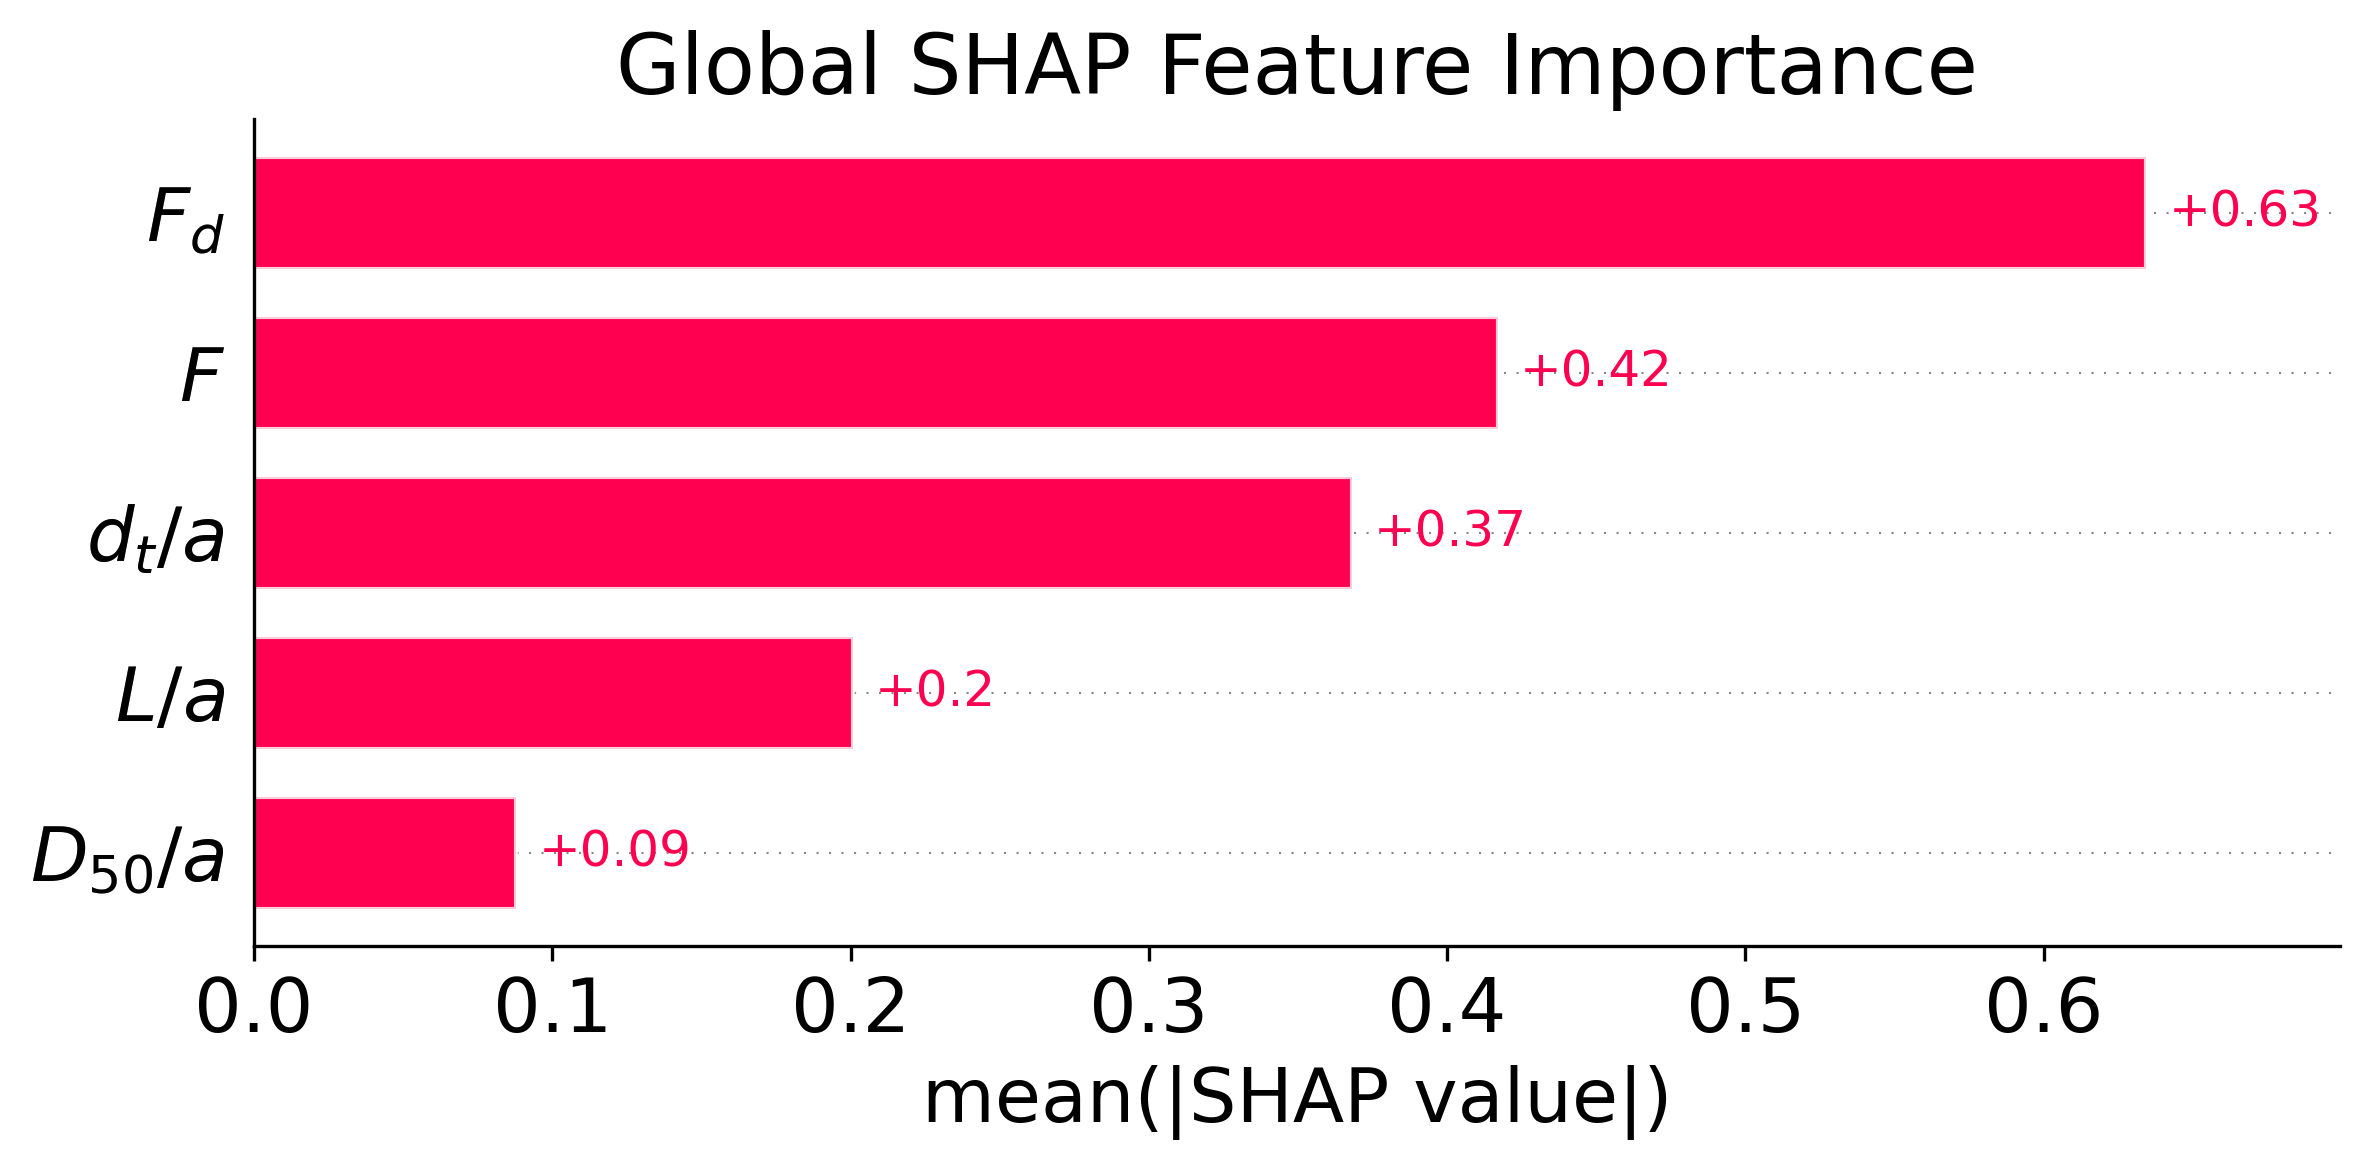

In [21]:
import shap
import matplotlib.pyplot as plt

# shap_values.values: (n_samples, n_features)
# shap_values.data:   feature matrix
# shap_values.feature_names

base_fontsize = 18

# 1️⃣ Global importance
plt.figure(figsize=(8, 4), dpi=300)
shap.plots.bar(shap_values, show=False)
plt.title("Global SHAP Feature Importance", fontsize=base_fontsize+2)
plt.xlabel("mean(|SHAP value|)", fontsize=base_fontsize)
# plt.ylabel("Predicted scour depth $\\hat{d}_s$")

# Tick label font size
plt.xticks(fontsize=base_fontsize)
plt.yticks(fontsize=base_fontsize)

plt.tight_layout()
plt.savefig(f"SHAP_global_{base_dataset}.png", dpi=300)
plt.show()



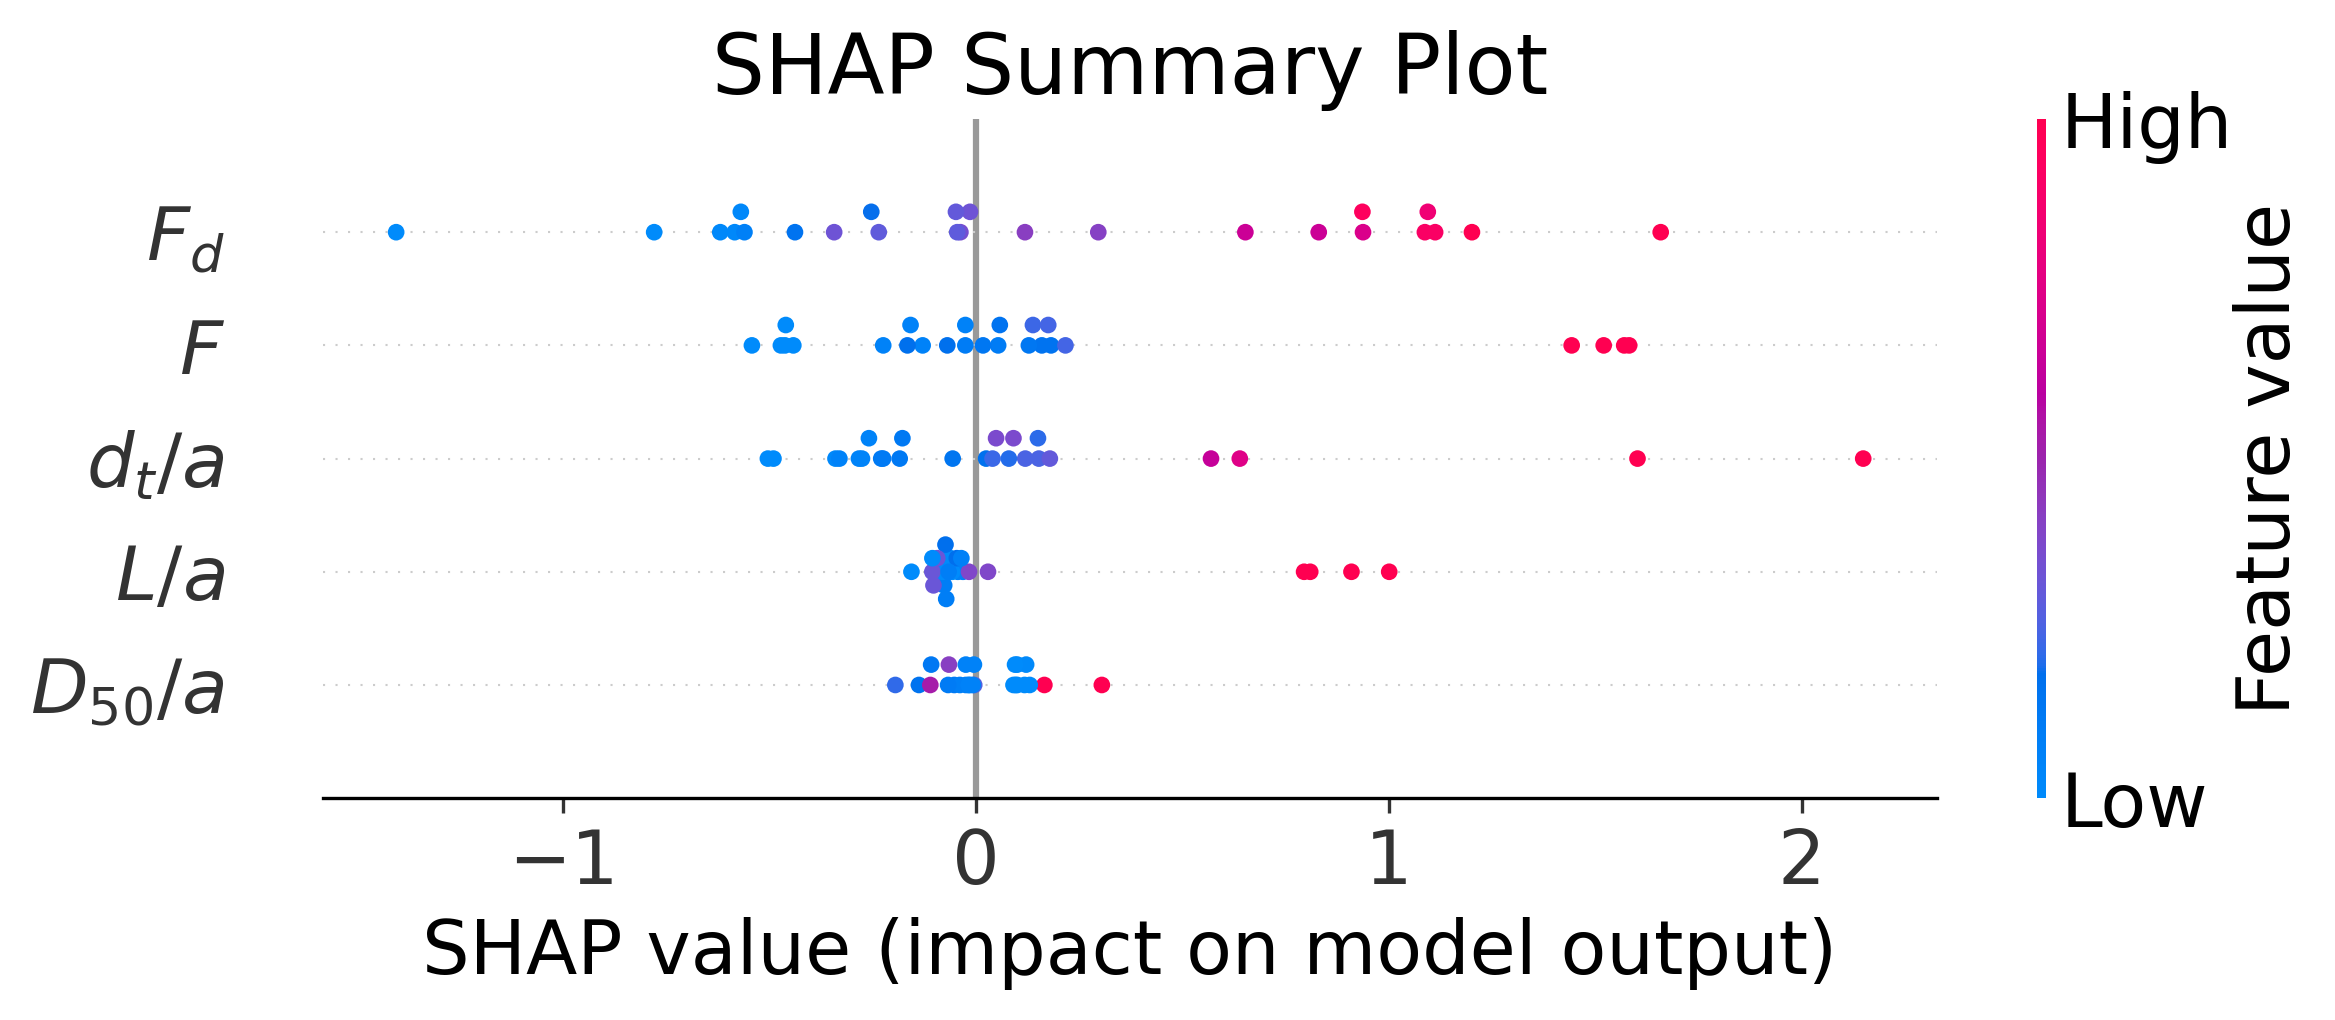

In [22]:
import matplotlib.pyplot as plt

base_fontsize = 18

plt.figure(figsize=(4, 8), dpi=300)
shap.plots.beeswarm(shap_values, show=False)

# Get current figure and axes
fig = plt.gcf()
axes = fig.axes

# Axis 0: main beeswarm plot
axes[0].set_title("SHAP Summary Plot", fontsize=base_fontsize + 2)
axes[0].set_xlabel(
    "SHAP value (impact on model output)",
    fontsize=base_fontsize
)
axes[0].tick_params(axis="both", labelsize=base_fontsize)

# Axis 1: colorbar (feature value)
axes[1].set_ylabel(
    "Feature value",
    fontsize=base_fontsize
)
axes[1].tick_params(labelsize=base_fontsize)

plt.tight_layout()
plt.savefig(f"SHAP_summary_{base_dataset}.png", dpi=300)
plt.show()


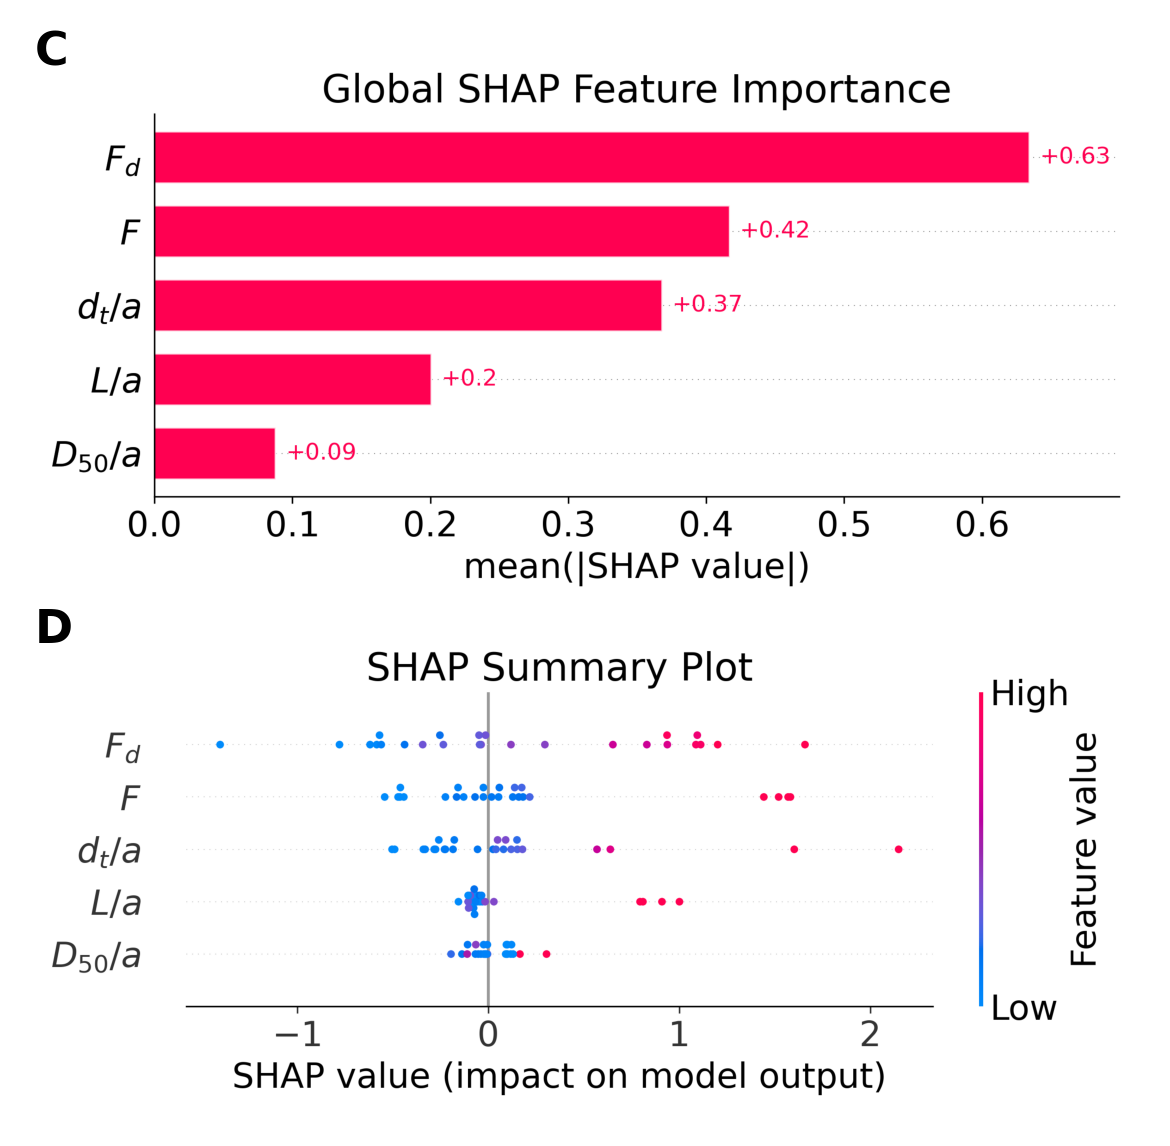

In [31]:
#Combine the two plots WITH labels
from PIL import Image
import matplotlib.pyplot as plt

# Load individual SHAP figures
img1 = Image.open(f"SHAP_global_{base_dataset}.png")
img2 = Image.open(f"SHAP_summary_{base_dataset}.png")

gap = 50
# Combine images vertically
width = max(img1.width, img2.width)
height = img1.height + img2.height + gap

combined = Image.new("RGB", (width, height), "white")
combined.paste(img1, (0, 0))
combined.paste(img2, (0, img1.height + gap))

# Plot combined image using Matplotlib
plt.figure(figsize=(4, 8), dpi=300)
plt.imshow(combined)
plt.axis("off")

# Add panel labels
if base_dataset=="Culvert":
  plt.text(10, 25, "A", fontsize=11, fontweight="bold")#, fontweight="bold"
  plt.text(10, img1.height + 25 + gap, "B", fontsize=11, fontweight="bold")#, fontweight="bold"
else:
  plt.text(10, 25, "C", fontsize=11, fontweight="bold")#, fontweight="bold"
  plt.text(10, img1.height + 25 + gap, "D", fontsize=11, fontweight="bold")#, fontweight="bold"

plt.tight_layout()

# ✅ SAVE THE MATPLOTLIB FIGURE (labels included)
plt.savefig(f"SHAP_combined_{base_dataset}.png", dpi=300, bbox_inches="tight")
plt.show()


#UNCERTAINTY

## Introduction to Uncertainty of TabPFN / Quantile Regresison

---



TabPFN is trained to predict the distribution of the target variable and not just a single point. This is also the case for regression.

As a result, we natively obtain uncertainty for the predictions of TabPFN (without the need for a new model or repeating models for different quantiles).

In the following, we plot the uncertainty of TabPFN

## Start

### Generate Quantile Predictions

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from tabpfn import TabPFNRegressor

# Fit TabPFN
# reg = TabPFNRegressor()
reg = TabPFNRegressor(
    model_path="tabpfn-v2.5-regressor-v2.5_default.ckpt"
)
reg.fit(X, y)

# Predict full distribution
preds = reg.predict(X, output_type="full")

# Extract quantiles
quantiles = np.array(preds["quantiles"])  # shape: (n_quantiles, n_samples)

# Common quantiles (TabPFN default)
q10 = quantiles[1]   # ~0.1
q50 = quantiles[4]   # ~0.5 (median)
q90 = quantiles[7]   # ~0.9

quantiles.shape


(9, 432)

### Observed vs Predicted with Prediction Intervals
This is the key uncertainty figure reviewers expect.

In [25]:
if base_dataset == "Culvert":
  gate = "Culvert"#Culvert/Sluice
else:
  gate = "Sluice"#Culvert/Sluice
len(set(y))

171

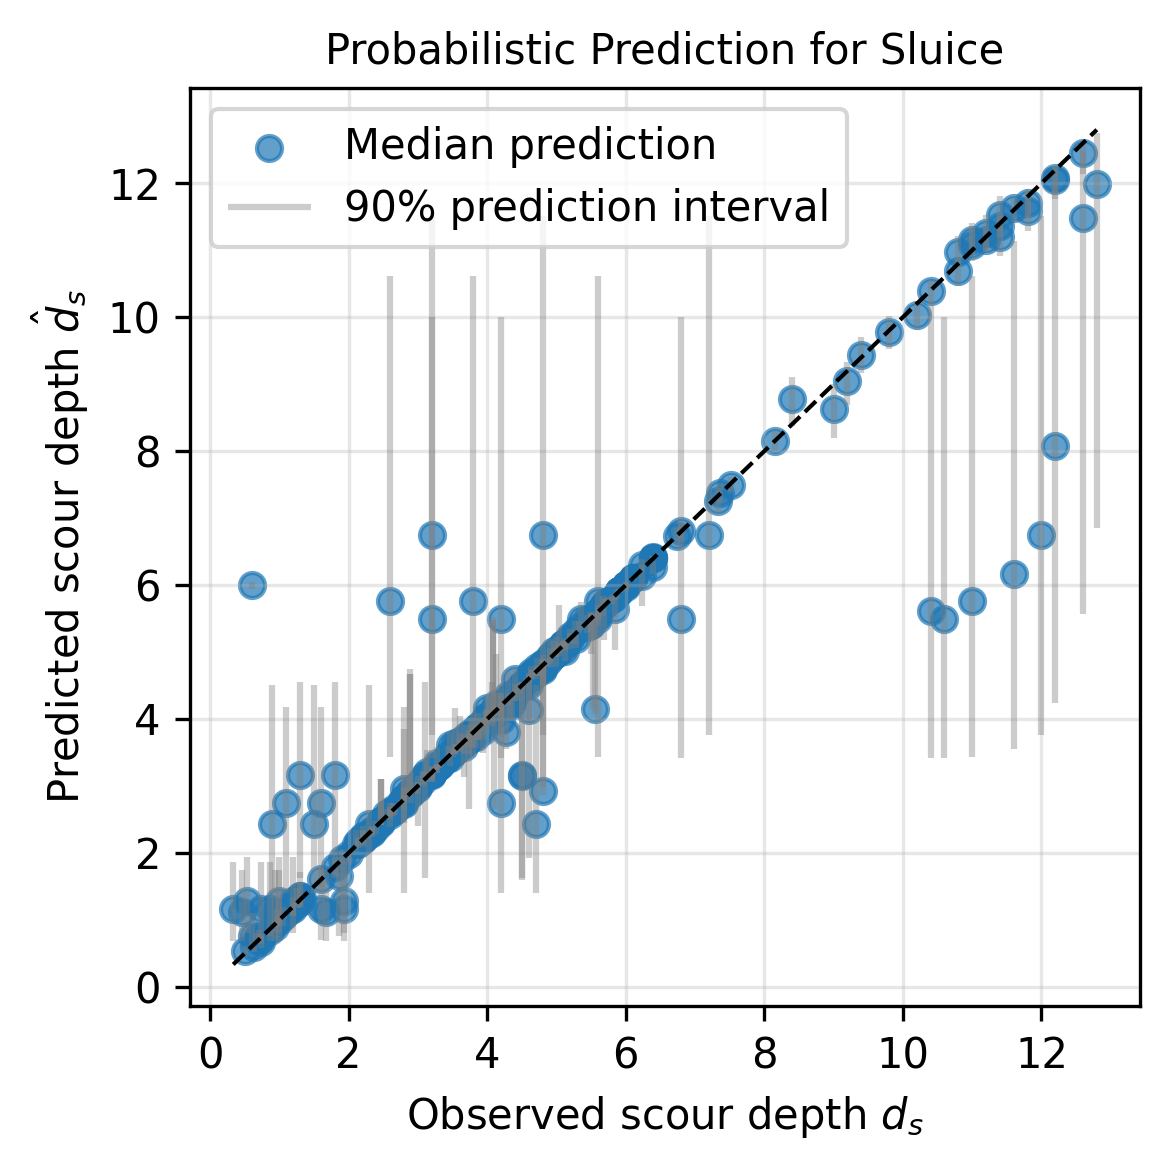

In [26]:
plt.figure(figsize=(4, 4), dpi=300)

# Scatter: median prediction
plt.scatter(y, q50, c="tab:blue", alpha=0.7, label="Median prediction")

# Prediction intervals
plt.vlines(
    y,
    q10,
    q90,
    color="gray",
    alpha=0.4,
    linewidth=1.5,
    label="90% prediction interval"
)

# 1:1 reference line
lims = [min(y.min(), q10.min()), max(y.max(), q90.max())]
plt.plot(lims, lims, "k--", linewidth=1)

plt.xlabel("Observed scour depth $d_s$")
plt.ylabel("Predicted scour depth $\\hat{d}_s$")
plt.title(f"Probabilistic Prediction for {gate}", fontsize=10)
plt.legend()
# Tick label font size
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)

plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f"Uncertainty_Probabilistic_Prediction_{base_dataset}.png", dpi=300, bbox_inches="tight")
plt.show()


### Uncertainty vs Densimetric Froude Number
This figure links uncertainty to hydraulics (very strong contribution).

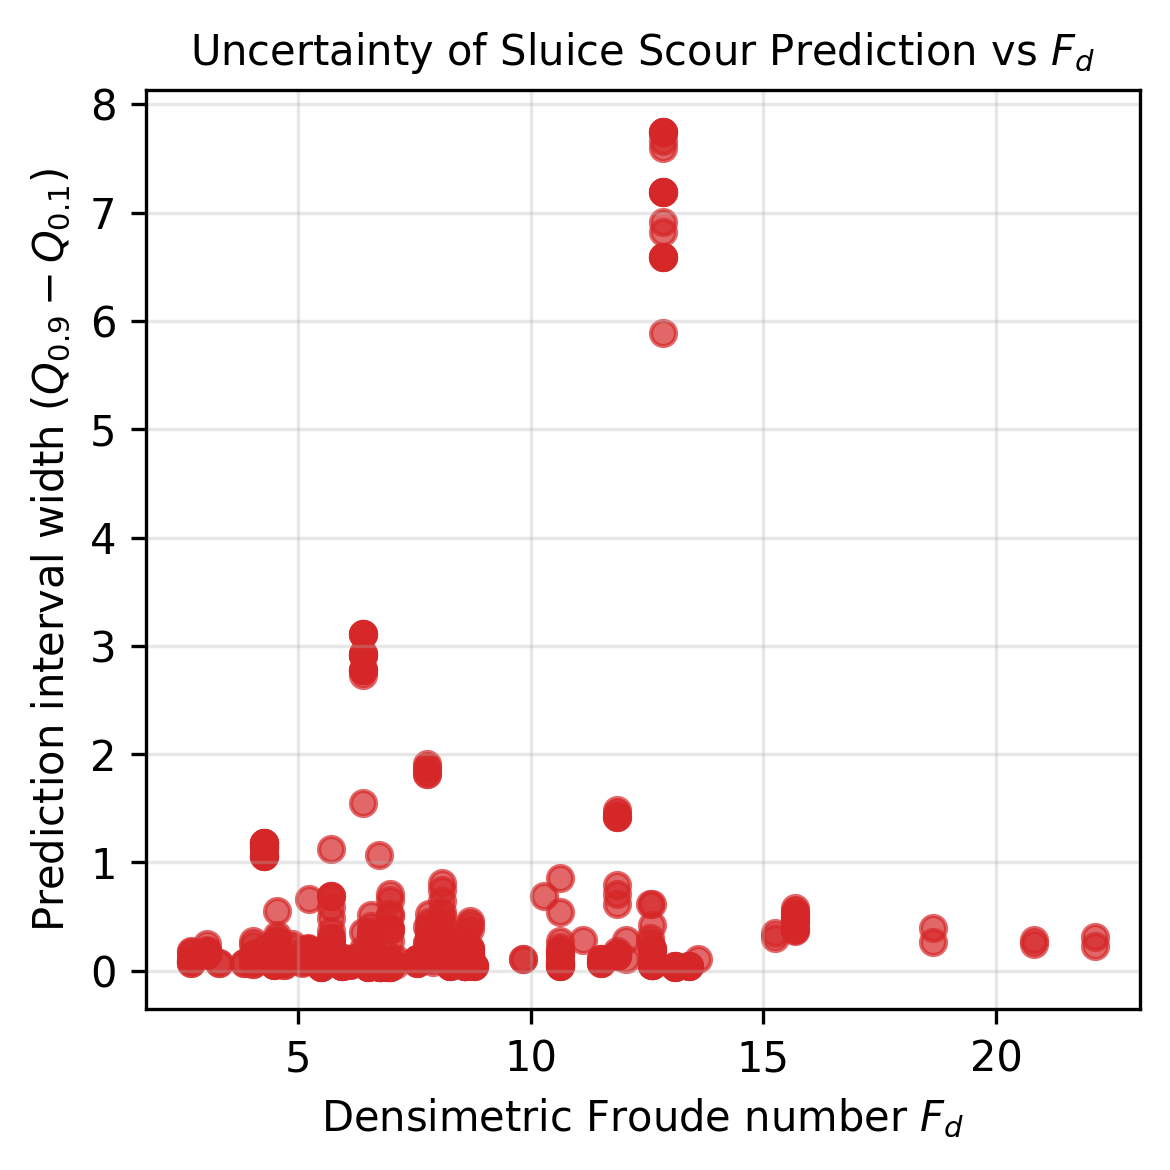

In [27]:
# Compute uncertainty width
uncertainty_width = q90 - q10

Fd = X["Fd"].values if hasattr(X, "columns") else X[:, 0]  # adjust index if needed

plt.figure(figsize=(4, 4), dpi=300)
plt.scatter(Fd, uncertainty_width, c="tab:red", alpha=0.7)

plt.xlabel("Densimetric Froude number $F_d$")
plt.ylabel("Prediction interval width $(Q_{0.9} - Q_{0.1})$")
plt.title(f"Uncertainty of {gate} Scour Prediction vs $F_d$", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f"Uncertainty_Prediction_vs_Fd_{base_dataset}.png", dpi=300, bbox_inches="tight")
plt.show()


### Combine the two plots

In [28]:
base_dataset = "Sluice"

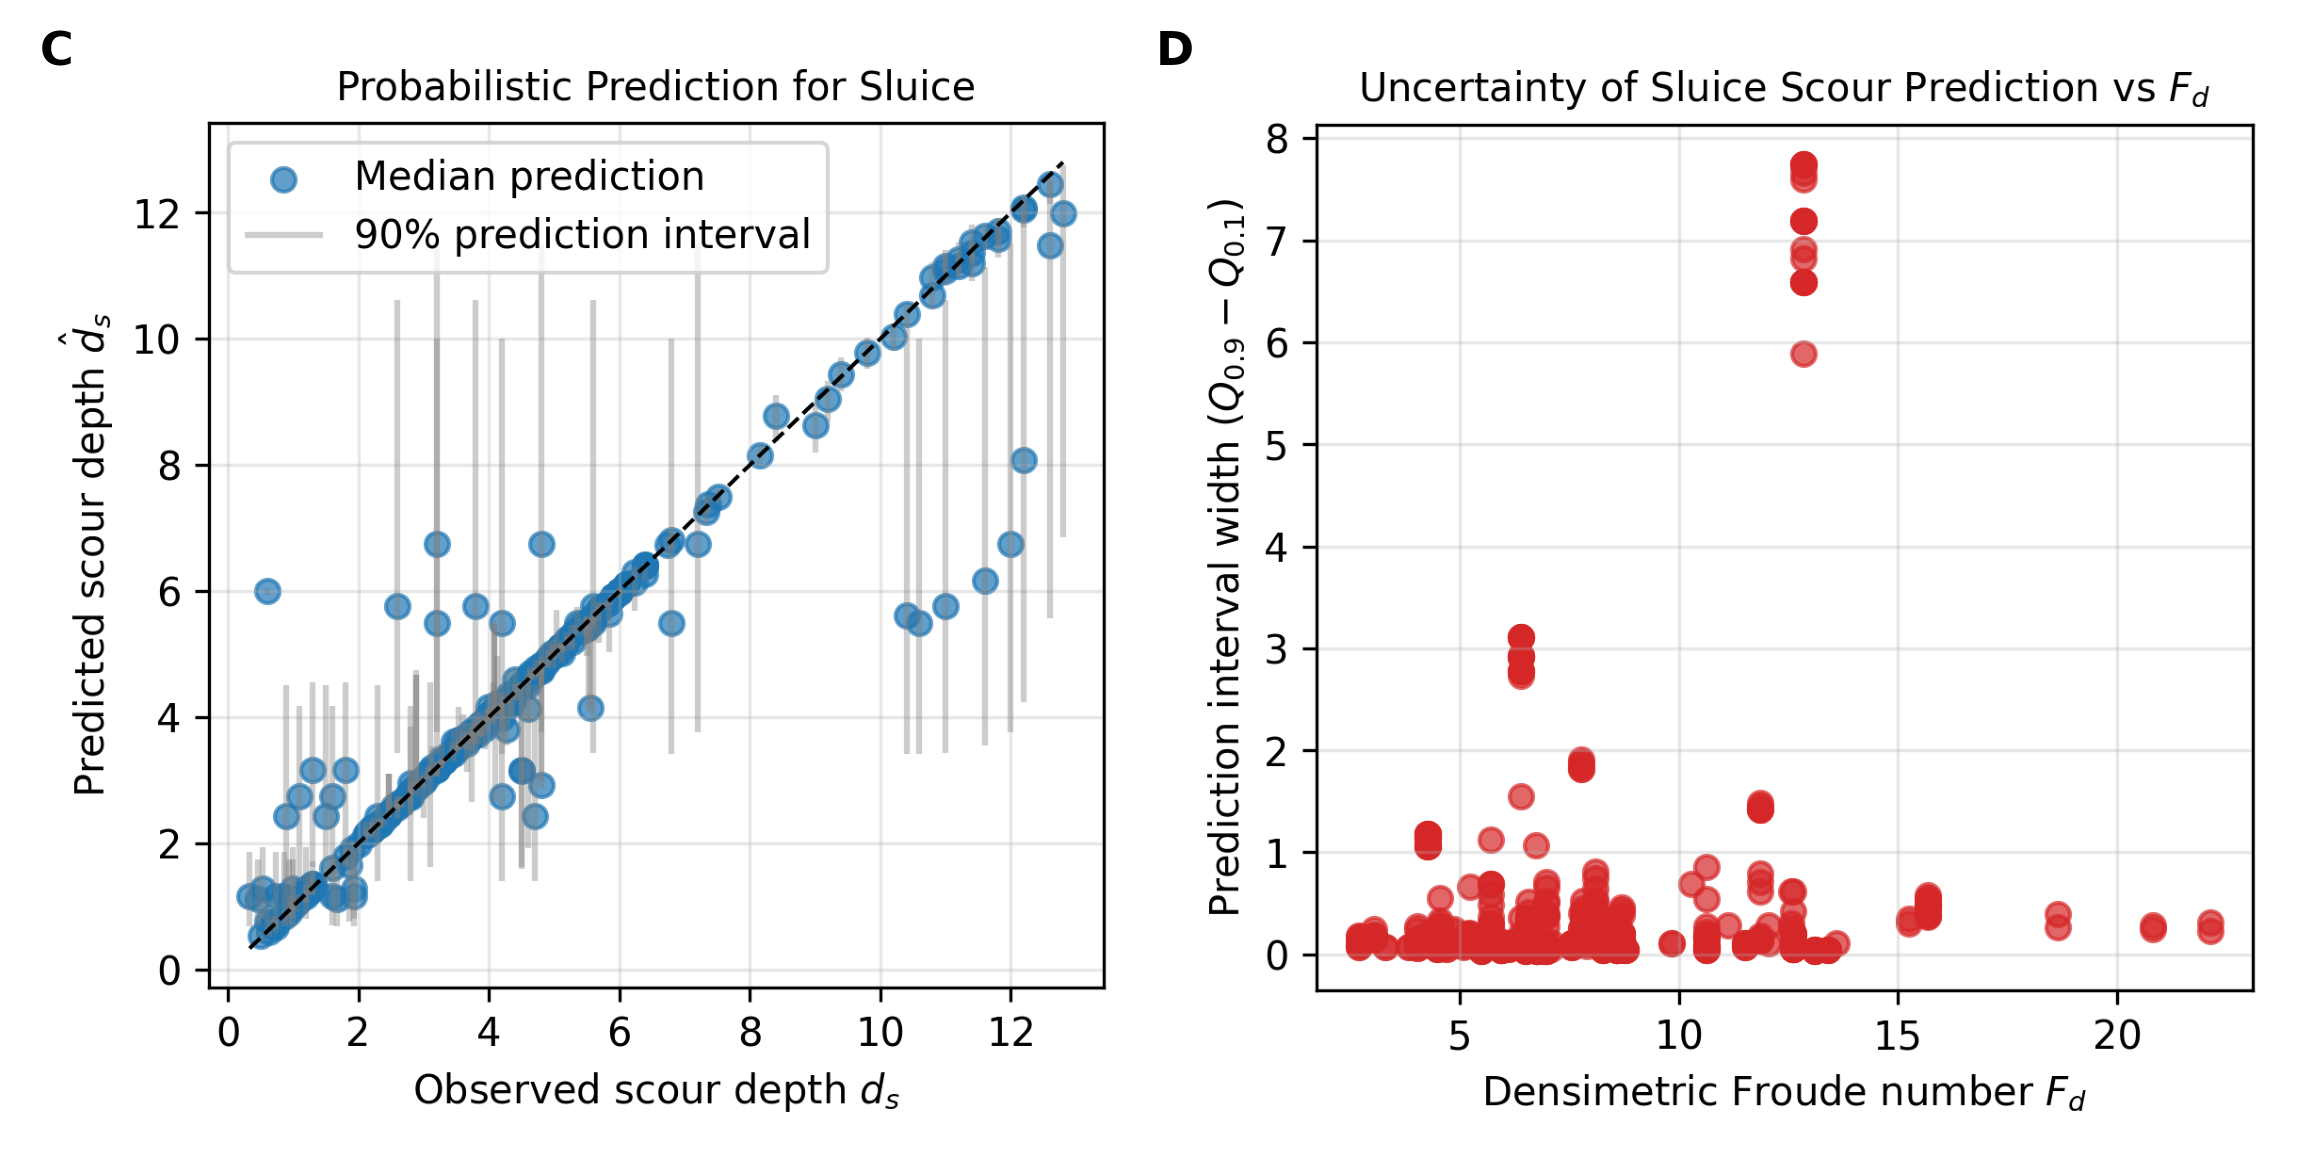

In [30]:
from PIL import Image
import matplotlib.pyplot as plt

# Load individual SHAP figures
img1 = Image.open(f"Uncertainty_Probabilistic_Prediction_{base_dataset}.png")
img2 = Image.open(f"Uncertainty_Prediction_vs_Fd_{base_dataset}.png")

gap = 50
# Combine images vertically
width = img1.width + img2.width + gap
height = max(img1.height, img2.height)


combined = Image.new("RGB", (width, height), "white")
combined.paste(img1, (0, 0))
combined.paste(img2, (img1.width+gap, 0))

# Plot combined image using Matplotlib
plt.figure(figsize=(8, 4), dpi=300)
plt.imshow(combined)
plt.axis("off")

# Add panel labels
if base_dataset=="Culvert":
  plt.text(10, 25, "A", fontsize=11, fontweight="bold")#, fontweight="bold"
  plt.text(img1.height + 25, 25, "B", fontsize=11, fontweight="bold")#, fontweight="bold"
else:
  plt.text(10, 25, "C", fontsize=11, fontweight="bold")#, fontweight="bold"
  plt.text(img1.height + 25, 25, "D", fontsize=11, fontweight="bold")#, fontweight="bold"

plt.tight_layout()

# ✅ SAVE THE MATPLOTLIB FIGURE (labels included)
plt.savefig(f"Uncertainty_Final_{base_dataset}.png", dpi=300, bbox_inches="tight")
plt.show()
